In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['axes.unicode_minus'] = False

In [44]:
plt.style.use("seaborn-whitegrid") 

In [2]:
# Number of time intervals in a day
H = 4

# Number of users
N = 3

# Price coefficient
g = 0.001
b = 0.1

# Error bound
epsilon = 1e-10

# dif bound [judge convergence]
dif = 1e-3

# Iteration times
T = 10

# Parameters
Vmax = 100

Pmax = 100
Pmin = 0.1

Smax = 1

In [47]:
class User:
    def __init__(self, h: int, a: int, w: list = None, x_user: list = None, x_sch: list = None, s_user: list = None,
                 t_sch: list = None) -> None:
        """
        :param h: Total number of hours a day
        :param a: Total number of the user's appliance
        :param w: Coefficient of preference
        :param x_user: Electricity consumption of the user
        :param x_sch: Scheduled electricity consumption of the user
        :param s_user: Storage consumption of the user
        """
        self.price = 1
        self.time = 0
        self.num_appliance = a
        self.x_flag = np.zeros(h)
        self.s_flag = np.zeros(h)
        self.x_converge_time = np.zeros(h)
        self.s_converge_time = np.zeros(h)
        if w is None:
            self.w = np.random.random(a) + 0.02 #这里加了一点儿截距项
        else:
            self.w = w
        if x_user is None:
            self.x_user = np.random.random((h, a)) * 10
        else:
            self.x_user = x_user
        if x_sch is None:
            self.x_sch = np.zeros((h, a))
        else:
            self.x_sch = x_sch
        if s_user is None:
            self.s_user = np.random.random(h)
        else:
            self.s_user = s_user
        if t_sch is None:
            self.t_sch = np.random.randint(low=0, high=h, size=(a, 2))
            for h_ in range(h):
                for a_ in range(self.num_appliance):
                    if self.t_sch[a_][0] <= h_ <= self.t_sch[a_][1]:
                        self.x_sch[h_, a_] = np.random.random() * 10
                    elif self.t_sch[a_][0] > self.t_sch[a_][1] and (h_ >= self.t_sch[a_][0] or h_ <= self.t_sch[a_][1]):
                        self.x_sch[h_, a_] = np.random.random() * 10
        else:
            self.t_sch = t_sch
        print(self.t_sch)

    def change(self, x_user_new: float, s_user_new: float) -> None:
        """
        Change the user's strategy
        :param x_user_new: New electricity consumption
        :param s_user_new: New storage consumption
        """
        if self.x_flag[self.time] == 0:
            self.x_user[self.time] = x_user_new
        if self.s_flag[self.time] == 0:
            self.s_user[self.time] = s_user_new
        return 

    def change_flag(self,x_user_new: float, s_user_new: float,day:int):
        if(abs(self.x_user[self.time]-x_user_new) < dif).all():
            self.x_flag[self.time] = 1
            self.x_converge_time[self.time] = day
        if(abs(self.s_user[self.time]-s_user_new) < dif):
            self.s_flag[self.time] = 1
            self.s_converge_time[self.time] = day
    
    def is_unchanged(self, x_user_new: float, s_user_new: float) -> bool:
        """
        Judge if there is a change
        :param x_user_new: New electricity consumption
        :param s_user_new: New storage consumption
        :return: If there is a change
        """
        return np.all(self.x_user - epsilon <= x_user_new <= self.x_user + epsilon) and np.all(
            self.s_user - epsilon <= s_user_new <= self.s_user + epsilon)

    def is_used(self) -> list:
        """
        Judge if all appliance used at some time interval
        :return: If all appliance used at some time interval
        """
        is_use_list = np.zeros(self.num_appliance)
        for i in range(self.num_appliance):
            if self.t_sch[i][0] <= self.t_sch[i][1]:
                is_use_list[i] = self.t_sch[i][0] <= self.time <= self.t_sch[i][1]
            else:
                is_use_list[i] = self.time >= self.t_sch[i][0] or self.time <= self.t_sch[i][1]
        return is_use_list

    def charge_t(self) -> float:
        """
        Calculate the user's electric charge of time t
        :return: electric charge
        """
        return self.price * (np.sum(np.sum(self.x_user)) + np.sum(self.s_user))

    def discomfort_t(self) -> float:
        """
        Calculate the user's discomfort of time t
        :return: discomfort
        """
        return np.sum(np.multiply(self.w, (self.x_user[self.time] - self.x_sch[self.time]) ** 2))

    def sum_cost_t(self, x: list = None) -> float:
        """
        Calculate the user's total cost of time t
        :return:
        """
        if x is None:
            return self.price * (self.x_user[self.time] + self.s_user[self.time]) \
                   / (np.sum(self.x_user) + np.sum(self.s_user)) \
                   + b \
                   + np.sum(np.multiply(self.w, (self.x_user[self.time] - self.x_sch[self.time]) ** 2))
        else:
            return self.price * (sum(x)) / (np.sum(self.x_user) + np.sum(self.s_user)) \
                   + np.sum(np.multiply(self.w, (x[:-1] - self.x_sch[self.time]) ** 2))


class Electricity:
    def __init__(self, n: int, h: int, e_sch=None, l=None):
        """
        :param n: Number of users
        :param l: List of users
        """
        self.time = np.arange(h).__iter__()
        self.t = 0
        self.t_flag = np.zeros(h)
        if l is None:
            self.user_list = [User(h, np.random.randint(3, 7)) for _ in range(n)]
        else:
            self.user_list = l
        if e_sch is None:
            self.e_sch = np.random.randint(low=0, high=h, size=2)
        else:
            self.e_sch = e_sch
        print(self.e_sch)

    def set_time(self):
        self.t = self.time.__next__()
        return self.t

    def is_not_power(self):
        return not self.t in range(np.min(self.e_sch), np.max(self.e_sch) + 1)

    def set_price_t(self, g):
        """
        Calculate the price of the electricity
        :return: price (P(t)=g*Lt^2)
        """
        total_t = 0
        for i in range(len(self.user_list)):
            total_t += np.sum(self.user_list[i].x_user[self.t]) + self.user_list[i].s_user[self.t]
            self.user_list[i].time = self.t
        Total = 0
        for i in range(len(self.user_list)):
            Total += np.sum(np.sum(self.user_list[i].x_user)) + np.sum(self.user_list[i].s_user)
        for i in range(len(self.user_list)):
            self.user_list[i].price = g * total_t ** 2 / Total
            
    def judge_converge_t(self):
        exit_x = 0
        exit_s = 0
        prod = 1
        for i in range(len(self.user_list)):
            prod = prod * self.user_list[i].x_flag[self.t]
        if prod != 0:
            #print('all strategy x converge at time {}!'.format(self.t))
            exit_x = 1
        prod = 1
        for i in range(len(self.user_list)):
            prod = prod * self.user_list[i].s_flag[self.t]
        if prod != 0:
            #print('all strategy s converge at time {}!'.format(self.t))
            exit_s = 1
        if (exit_x == 1) and (exit_s == 1):
            self.t_flag[self.t] = 1
    
    def reset_time(self, h):
        self.time = np.arange(h).__iter__()


In [49]:
from scipy.optimize import minimize

np.random.seed(2018012705)

e = Electricity(N, H)


converge_indicator = np.zeros(H)
user_x_list = np.zeros((N, H, T))
user_s_list = np.zeros((N, H, T))
par_list = np.zeros(T)

for day in range(T):
    if np.prod(converge_indicator) != 0:
        break
    else:
        print('Day:', day)
        try:
            while True:
                time = e.set_time()
                print('-' * 50)
                print('Hour:', time)
                if e.t_flag[time] == 1:
                    print('All strategies have already converged at time {}'.format(time))
                    converge_indicator[time] = 1
                else:
                    price = e.set_price_t(g)
                    # print('Price:', price)

                    for u in range(N):
                        print('!! User:', u)
                        print('Strategy_x:', e.user_list[u].x_user[time])
                        print('Strategy_s:', e.user_list[u].s_user[time])
                        print('Schedule_x:', e.user_list[u].x_sch[time])

                        fun = e.user_list[u].sum_cost_t
                        # print('Sum_cost:', fun(e.user_list[u].x_user[time].tolist() + [e.user_list[u].s_user[time]]))

                        print('Appliance is used:', [e.user_list[u].is_used()[i] for i in range(e.user_list[u].x_user[time].shape[0])])
                        print('Power supplied:', not e.is_not_power())

                        cons = (
                            # x_user >= Pmin when appliance works
                            {'type': 'ineq',
                             'fun': lambda x: x[:-1][np.where(e.user_list[u].is_used() == 1)] - Pmin},
                            # x_user <= Pmax when appliance works
                            {'type': 'ineq',
                             'fun': lambda x: - x[:-1][np.where(e.user_list[u].is_used() == 1)] + Pmax},
                            # x_user = 0 when appliance does not work
                            {'type': 'eq',
                             'fun': lambda x: x[:-1][np.where(e.user_list[u].is_used() == 0)]},
                            # s_user >= 0 when electricity is supplied
                            {'type': 'ineq',
                             'fun': lambda x: x[-1] if not e.is_not_power() else 1},
                            # s_user <= 0 when electricity is not supplied
                            {'type': 'ineq',
                             'fun': lambda x: -x[-1] if e.is_not_power() else 1},
                            # s_user >= -Vmax
                            {'type': 'ineq',
                             'fun': lambda x: x[-1] + Vmax},
                            # sum(x_user) + s_user = 0 when electricity is not supplied
                            {'type': 'eq',
                             'fun': lambda x: np.sum(x) if e.is_not_power() else 0},
                            # sum(s_user) ≈ 0
                            {'type': 'eq',
                             'fun': lambda x: x[-1] + np.sum(e.user_list[u].s_user) + Smax},
                        )

                        res = minimize(fun, e.user_list[u].x_user[time].tolist() + [e.user_list[u].s_user[time]],
                                       method='SLSQP', constraints=cons, tol=1e-6, options={'maxiter': 10, 'disp': False})
                        x_new, s_new = res.x[:-1], res.x[-1]
                        print('Strategy_x_new:', x_new)
                        print('Strategy_s_new:', s_new)
                        user_x_list[u, time, day] = np.sum(x_new)
                        user_s_list[u, time, day] = s_new
                        e.user_list[u].change_flag(x_new,s_new,day)
                        e.user_list[u].change(x_new, s_new)
                    e.judge_converge_t()                

        except StopIteration:
            e.reset_time(H)
            print('=' * 50)


[[3 3]
 [3 3]
 [1 2]
 [0 2]
 [2 0]
 [3 1]]
[[2 0]
 [3 0]
 [3 3]
 [2 3]
 [2 2]]
[[3 0]
 [0 1]
 [0 1]
 [2 0]]
[2 1]
Day: 0
--------------------------------------------------
Hour: 0
!! User: 0
Strategy_x: [7.93979013 7.93503157 3.19240353 6.39853539 7.23934293 7.03631531]
Strategy_s: 0.9605827736453136
Schedule_x: [0.         0.         0.         9.58521719 8.86635108 9.38161162]
Appliance is used: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
Power supplied: False
Strategy_x_new: [0.         0.         0.         0.1        0.1        3.56776721]
Strategy_s_new: -3.767767213572282
!! User: 1
Strategy_x: [6.38683537 4.77488782 8.42368201 1.90248403 7.98716379]
Strategy_s: 0.38875006040814164
Schedule_x: [4.69437843 4.19245485 0.         0.         0.        ]
Appliance is used: [1.0, 1.0, 0.0, 0.0, 0.0]
Power supplied: False
Strategy_x_new: [3.07457621 0.2809485  0.         0.         0.        ]
Strategy_s_new: -3.355524709250335
!! User: 2
Strategy_x: [9.66402349 4.04661896 5.71977238 0.81877058]
St

Strategy_x_new: [0.10000002 0.1        0.         0.         0.        ]
Strategy_s_new: -0.20000001503121156
!! User: 2
Strategy_x: [0.1897038  0.1        0.75577586 0.1       ]
Strategy_s: -1.1454796569304613
Schedule_x: [4.8703104  4.66030069 6.67861424 0.54097403]
Appliance is used: [1.0, 1.0, 1.0, 1.0]
Power supplied: False
Strategy_x_new: [0.1 0.1 0.1 0.1]
Strategy_s_new: -0.40000000034723937
--------------------------------------------------
Hour: 1
All strategies have already converged at time 1
--------------------------------------------------
Hour: 2
All strategies have already converged at time 2
--------------------------------------------------
Hour: 3
!! User: 0
Strategy_x: [0.1 0.1 0.  0.  0.1 0.1]
Strategy_s: 0.8070790901925154
Schedule_x: [6.77467501 7.81183941 0.         0.         1.36927033 2.50846609]
Appliance is used: [1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
Power supplied: False
Strategy_x_new: [2.20718444 0.1        0.         0.         0.1        0.1       ]
Strategy_

Strategy_x_new: [0.1 0.1 0.1 0.1 0. ]
Strategy_s_new: -0.11246055887030304
!! User: 2
Strategy_x: [1.04547966 0.         0.         0.1       ]
Strategy_s: 0.190534641506106
Schedule_x: [6.52029942 0.         0.         1.91870619]
Appliance is used: [1.0, 0.0, 0.0, 1.0]
Power supplied: False
Strategy_x_new: [0.3 0.  0.  0.1]
Strategy_s_new: -0.40000000034723904
Day: 9
--------------------------------------------------
Hour: 0
!! User: 0
Strategy_x: [0.         0.         0.         0.1        0.1        2.30718444]
Strategy_s: -2.5071844399269647
Schedule_x: [0.         0.         0.         9.58521719 8.86635108 9.38161162]
Appliance is used: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
Power supplied: False
Strategy_x_new: [0.  0.  0.  0.1 0.1 0.1]
Strategy_s_new: -0.30000000000000426
!! User: 1
Strategy_x: [2.66677463 0.1        0.         0.         0.        ]
Strategy_s: -2.7667746338109853
Schedule_x: [4.69437843 4.19245485 0.         0.         0.        ]
Appliance is used: [1.0, 1.0, 0.0,

In [37]:
def PAR(user_x_list,user_s_list):
    user_l_list = user_x_list + user_s_list
    large_L = np.sum(user_l_list,axis = 0)
    avg_L = np.mean(large_L,axis = 0)
    max_L = np.max(large_L,axis = 0)
    par = max_L/avg_L
    plt.plot(par)
    plt.xlabel('Day')
    plt.ylabel('PAR')
    plt.show()

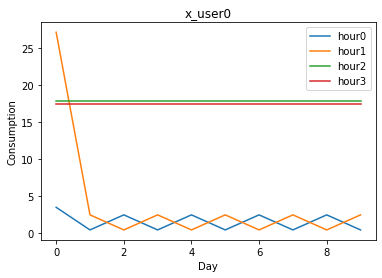

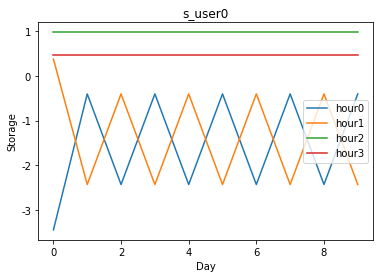

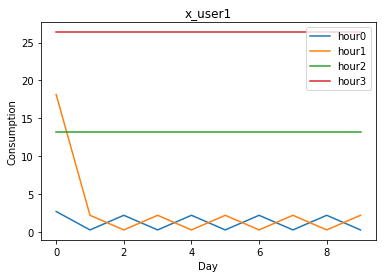

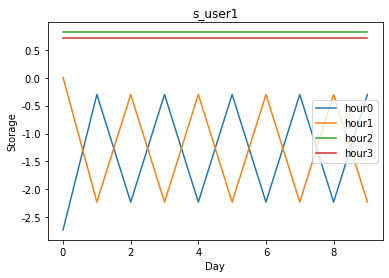

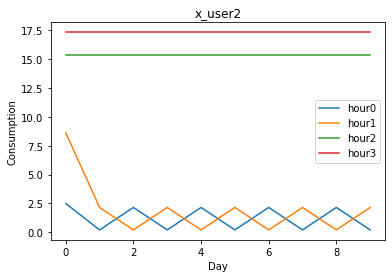

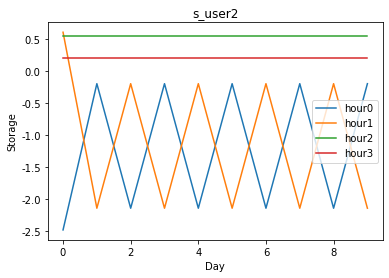

In [17]:
# print(user_x_list)
# print(user_s_list)
# from matplotlib import pyplot as plt
# random seed = 42
for i in range(N):
    plt.close()
    tmp = pd.DataFrame(user_x_list[i].T,columns = ['hour0','hour1','hour2','hour3']) 
    plt.plot(tmp)
    plt.xlabel('Day')
    plt.ylabel('Consumption')
    plt.title('x_user{}'.format(i))
    plt.legend(labels = ['hour0','hour1','hour2','hour3'],loc = 'best')
    #plt.savefig('%i-x.pdf' % i)
    plt.show()
    plt.close()
    tmp = pd.DataFrame(user_s_list[i].T,columns = ['hour0','hour1','hour2','hour3']) 
    plt.plot(tmp)
    plt.xlabel('Day')
    plt.ylabel('Storage')
    plt.legend(labels = ['hour0','hour1','hour2','hour3'],loc = 'best')
    plt.title('s_user{}'.format(i))
    plt.show()

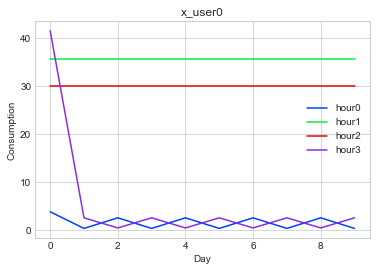

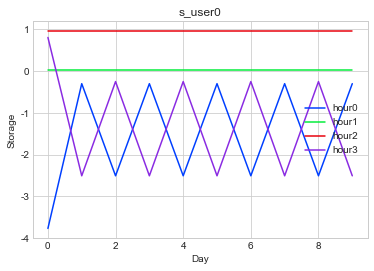

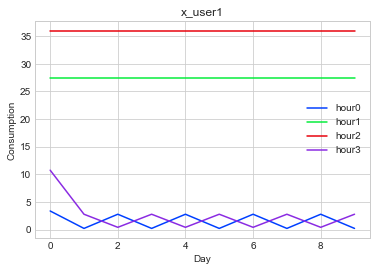

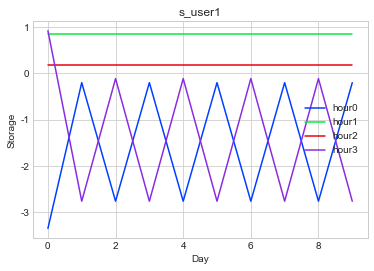

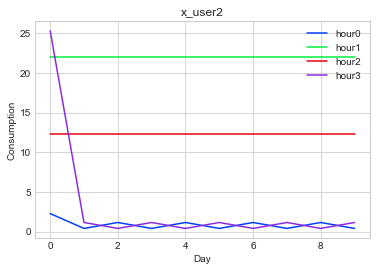

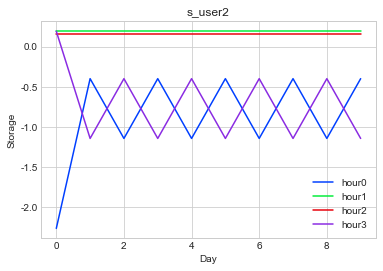

In [45]:
# random seed = 2018012705
for i in range(N):
    plt.close()
    tmp = pd.DataFrame(user_x_list[i].T,columns = ['hour0','hour1','hour2','hour3']) 
    plt.plot(tmp)
    plt.xlabel('Day')
    plt.ylabel('Consumption')
    plt.title('x_user{}'.format(i))
    plt.legend(labels = ['hour0','hour1','hour2','hour3'],loc = 'best')
    #plt.savefig('%i-x.pdf' % i)
    plt.show()
    plt.close()
    tmp = pd.DataFrame(user_s_list[i].T,columns = ['hour0','hour1','hour2','hour3']) 
    plt.plot(tmp)
    plt.xlabel('Day')
    plt.ylabel('Storage')
    plt.legend(labels = ['hour0','hour1','hour2','hour3'],loc = 'best')
    plt.title('s_user{}'.format(i))
    plt.show()

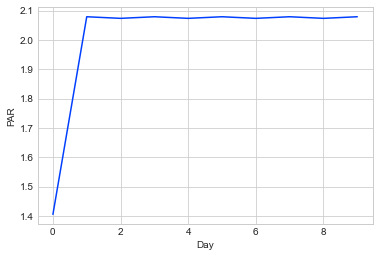

In [46]:
PAR(user_x_list,user_s_list)

## 更新

In [54]:
class User:
    def __init__(self, h: int, a: int, w: list = None, x_user: list = None, x_sch: list = None, s_user: list = None,
                 t_sch: list = None) -> None:
        """
        :param h: Total number of hours a day
        :param a: Total number of the user's appliance
        :param w: Coefficient of preference
        :param x_user: Electricity consumption of the user
        :param x_sch: Scheduled electricity consumption of the user
        :param s_user: Storage consumption of the user
        """
        self.price = 1
        self.time = 0
        self.num_appliance = a
        self.x_flag = np.zeros(h)
        self.s_flag = np.zeros(h)
        self.x_converge_time = np.zeros(h)
        self.s_converge_time = np.zeros(h)
        if w is None:
            self.w = np.random.random(a) + 0.02 #这里加了一点儿截距项
        else:
            self.w = w
        if x_user is None:
            self.x_user = np.random.random((h, a)) * 10
            self.x_user_copy = self.x_user.copy()
        else:
            self.x_user = x_user
            self.x_user_copy = x_user
        if x_sch is None:
            self.x_sch = np.zeros((h, a))
        else:
            self.x_sch = x_sch
        if s_user is None:
            self.s_user = np.random.random(h)
            self.s_user_copy = self.s_user.copy()
        else:
            self.s_user = s_user
            self.s_user = s_user
        if t_sch is None:
            self.t_sch = np.random.randint(low=0, high=h, size=(a, 2))
            for h_ in range(h):
                for a_ in range(self.num_appliance):
                    if self.t_sch[a_][0] <= h_ <= self.t_sch[a_][1]:
                        self.x_sch[h_, a_] = np.random.random() * 10
                    elif self.t_sch[a_][0] > self.t_sch[a_][1] and (h_ >= self.t_sch[a_][0] or h_ <= self.t_sch[a_][1]):
                        self.x_sch[h_, a_] = np.random.random() * 10
        else:
            self.t_sch = t_sch
        print(self.t_sch)

    def change(self, x_user_new: float, s_user_new: float) -> None:
        """
        Change the user's strategy
        :param x_user_new: New electricity consumption
        :param s_user_new: New storage consumption
        """
        if self.x_flag[self.time] == 0:
            self.x_user[self.time] = x_user_new
        if self.s_flag[self.time] == 0:
            self.s_user[self.time] = s_user_new
        return 

    def change_flag(self,x_user_new: float, s_user_new: float,day:int):
        if(abs(self.x_user[self.time]-x_user_new) < dif).all():
            self.x_flag[self.time] = 1
            self.x_converge_time[self.time] = day
        if(abs(self.s_user[self.time]-s_user_new) < dif):
            self.s_flag[self.time] = 1
            self.s_converge_time[self.time] = day
    
    def is_unchanged(self, x_user_new: float, s_user_new: float) -> bool:
        """
        Judge if there is a change
        :param x_user_new: New electricity consumption
        :param s_user_new: New storage consumption
        :return: If there is a change
        """
        return np.all(self.x_user - epsilon <= x_user_new <= self.x_user + epsilon) and np.all(
            self.s_user - epsilon <= s_user_new <= self.s_user + epsilon)

    def is_used(self) -> list:
        """
        Judge if all appliance used at some time interval
        :return: If all appliance used at some time interval
        """
        is_use_list = np.zeros(self.num_appliance)
        for i in range(self.num_appliance):
            if self.t_sch[i][0] <= self.t_sch[i][1]:
                is_use_list[i] = self.t_sch[i][0] <= self.time <= self.t_sch[i][1]
            else:
                is_use_list[i] = self.time >= self.t_sch[i][0] or self.time <= self.t_sch[i][1]
        return is_use_list

    def charge_t(self) -> float:
        """
        Calculate the user's electric charge of time t
        :return: electric charge
        """
        return self.price * (np.sum(np.sum(self.x_user)) + np.sum(self.s_user))

    def discomfort_t(self) -> float:
        """
        Calculate the user's discomfort of time t
        :return: discomfort
        """
        return np.sum(np.multiply(self.w, (self.x_user[self.time] - self.x_sch[self.time]) ** 2))

    def sum_cost_t(self, x: list = None) -> float:
        """
        Calculate the user's total cost of time t
        :return:
        """
        if x is None:
            return self.price * (self.x_user_copy[self.time] + self.s_user_copy[self.time]) \
                   / (np.sum(self.x_user_copy) + np.sum(self.s_user_copy)) \
                   + b \
                   + np.sum(np.multiply(self.w, (self.x_user_copy[self.time] - self.x_sch[self.time]) ** 2))
        else:
            return self.price * (sum(x)) / (np.sum(self.x_user_copy) + np.sum(self.s_user_copy)) \
                   + np.sum(np.multiply(self.w, (x[:-1] - self.x_sch[self.time]) ** 2))


class Electricity:
    def __init__(self, n: int, h: int, e_sch=None, l=None):
        """
        :param n: Number of users
        :param l: List of users
        """
        self.time = np.arange(h).__iter__()
        self.t = 0
        self.t_flag = np.zeros(h)
        if l is None:
            self.user_list = [User(h, np.random.randint(3, 7)) for _ in range(n)]
        else:
            self.user_list = l
        if e_sch is None:
            self.e_sch = np.random.randint(low=0, high=h, size=2)
        else:
            self.e_sch = e_sch
        print(self.e_sch)

    def set_time(self):
        self.t = self.time.__next__()
        return self.t

    def is_not_power(self):
        return not self.t in range(np.min(self.e_sch), np.max(self.e_sch) + 1)

    def set_price_t(self, g):
        """
        Calculate the price of the electricity
        :return: price (P(t)=g*Lt^2)
        """
        total_t = 0
        for i in range(len(self.user_list)):
            total_t += np.sum(self.user_list[i].x_user_copy[self.t]) + self.user_list[i].s_user_copy[self.t]
            self.user_list[i].time = self.t
        Total = 0
        for i in range(len(self.user_list)):
            Total += np.sum(np.sum(self.user_list[i].x_user_copy)) + np.sum(self.user_list[i].s_user_copy)
        for i in range(len(self.user_list)):
            self.user_list[i].price = g * total_t ** 2 / Total
            
    def judge_converge_t(self):
        exit_x = 1
        exit_s = 1
        prod = 1
        for i in range(len(self.user_list)):
            prod = prod * self.user_list[i].x_flag[self.t]
        if prod != 0:
            #print('all strategy x converge at time {}!'.format(self.t))
            exit_x = 0
        prod = 1
        for i in range(len(self.user_list)):
            prod = prod * self.user_list[i].s_flag[self.t]
        if prod != 0:
            #print('all strategy s converge at time {}!'.format(self.t))
            exit_s = 0
        if (exit_x == 0) and (exit_s == 1):
            self.t_flag[self.t] = 1
    
    def update(self):
        for i in range(len(self.user_list)):
            self.user_list[i].x_user_copy[self.t] = self.user_list[i].x_user[self.t].copy()
            self.user_list[i].s_user_copy[self.t] = self.user_list[i].s_user[self.t].copy()
    
    def reset_time(self, h):
        self.time = np.arange(h).__iter__()


In [55]:
from scipy.optimize import minimize

np.random.seed(2018012705)

e = Electricity(N, H)


converge_indicator = np.zeros(H)
user_x_list = np.zeros((N, H, T))
user_s_list = np.zeros((N, H, T))
par_list = np.zeros(T)

for day in range(T):
    if np.prod(converge_indicator) != 0:
        break
    else:
        print('Day:', day)
        try:
            while True:
                time = e.set_time()
                print('-' * 50)
                print('Hour:', time)
                if e.t_flag[time] == 1:
                    print('All strategies have already converged at time {}'.format(time))
                    converge_indicator[time] = 1
                else:
                    price = e.set_price_t(g)
                    # print('Price:', price)

                    for u in range(N):
                        print('!! User:', u)
                        print('Strategy_x:', e.user_list[u].x_user[time])
                        print('Strategy_s:', e.user_list[u].s_user[time])
                        print('Schedule_x:', e.user_list[u].x_sch[time])

                        fun = e.user_list[u].sum_cost_t
                        # print('Sum_cost:', fun(e.user_list[u].x_user[time].tolist() + [e.user_list[u].s_user[time]]))

                        print('Appliance is used:', [e.user_list[u].is_used()[i] for i in range(e.user_list[u].x_user[time].shape[0])])
                        print('Power supplied:', not e.is_not_power())

                        cons = (
                            # x_user >= Pmin when appliance works
                            {'type': 'ineq',
                             'fun': lambda x: x[:-1][np.where(e.user_list[u].is_used() == 1)] - Pmin},
                            # x_user <= Pmax when appliance works
                            {'type': 'ineq',
                             'fun': lambda x: - x[:-1][np.where(e.user_list[u].is_used() == 1)] + Pmax},
                            # x_user = 0 when appliance does not work
                            {'type': 'eq',
                             'fun': lambda x: x[:-1][np.where(e.user_list[u].is_used() == 0)]},
                            # s_user >= 0 when electricity is supplied
                            {'type': 'ineq',
                             'fun': lambda x: x[-1] if not e.is_not_power() else 1},
                            # s_user <= 0 when electricity is not supplied
                            {'type': 'ineq',
                             'fun': lambda x: -x[-1] if e.is_not_power() else 1},
                            # s_user >= -Vmax
                            {'type': 'ineq',
                             'fun': lambda x: x[-1] + Vmax},
                            # sum(x_user) + s_user = 0 when electricity is not supplied
                            {'type': 'eq',
                             'fun': lambda x: np.sum(x) if e.is_not_power() else 0},
                            # sum(s_user) ≈ 0
                            {'type': 'eq',
                             'fun': lambda x: x[-1] + np.sum(e.user_list[u].s_user) + Smax},
                        )

                        res = minimize(fun, e.user_list[u].x_user[time].tolist() + [e.user_list[u].s_user[time]],
                                       method='SLSQP', constraints=cons, tol=1e-6, options={'maxiter': 10, 'disp': False})
                        x_new, s_new = res.x[:-1], res.x[-1]
                        print('Strategy_x_new:', x_new)
                        print('Strategy_s_new:', s_new)
                        user_x_list[u, time, day] = np.sum(x_new)
                        user_s_list[u, time, day] = s_new
                        e.user_list[u].change_flag(x_new,s_new,day)
                        e.user_list[u].change(x_new, s_new)
                    e.update()
                    e.judge_converge_t()

        except StopIteration:
            e.reset_time(H)
            print('=' * 50)


[[3 3]
 [3 3]
 [1 2]
 [0 2]
 [2 0]
 [3 1]]
[[2 0]
 [3 0]
 [3 3]
 [2 3]
 [2 2]]
[[3 0]
 [0 1]
 [0 1]
 [2 0]]
[2 1]
Day: 0
--------------------------------------------------
Hour: 0
!! User: 0
Strategy_x: [7.93979013 7.93503157 3.19240353 6.39853539 7.23934293 7.03631531]
Strategy_s: 0.9605827736453136
Schedule_x: [0.         0.         0.         9.58521719 8.86635108 9.38161162]
Appliance is used: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
Power supplied: False
Strategy_x_new: [0.         0.         0.         0.1        0.1        3.56776721]
Strategy_s_new: -3.767767213572282
!! User: 1
Strategy_x: [6.38683537 4.77488782 8.42368201 1.90248403 7.98716379]
Strategy_s: 0.38875006040814164
Schedule_x: [4.69437843 4.19245485 0.         0.         0.        ]
Appliance is used: [1.0, 1.0, 0.0, 0.0, 0.0]
Power supplied: False
Strategy_x_new: [3.07457621 0.2809485  0.         0.         0.        ]
Strategy_s_new: -3.355524709250335
!! User: 2
Strategy_x: [9.66402349 4.04661896 5.71977238 0.81877058]
St

Strategy_x_new: [2.20718444 0.1        0.         0.         0.1        0.1       ]
Strategy_s_new: -2.5071844399269687
!! User: 1
Strategy_x: [0.1 0.1 0.1 0.1 0. ]
Strategy_s: 0.9234703404827759
Schedule_x: [6.30813513 2.72500578 3.95310816 8.54116465 0.        ]
Appliance is used: [1.0, 1.0, 1.0, 1.0, 0.0]
Power supplied: False
Strategy_x_new: [0.1        0.1        0.1        2.46677463 0.        ]
Strategy_s_new: -2.766774633810981
!! User: 2
Strategy_x: [0.3 0.  0.  0.1]
Strategy_s: 0.190534641506106
Schedule_x: [6.52029942 0.         0.         1.91870619]
Appliance is used: [1.0, 0.0, 0.0, 1.0]
Power supplied: False
Strategy_x_new: [1.04547966 0.         0.         0.1       ]
Strategy_s_new: -1.1454796569304613
Day: 4
--------------------------------------------------
Hour: 0
!! User: 0
Strategy_x: [0.         0.         0.         0.09999999 0.1        0.10000001]
Strategy_s: -0.3000000000000004
Schedule_x: [0.         0.         0.         9.58521719 8.86635108 9.38161162]
Ap

Strategy_x_new: [2.20718444 0.1        0.         0.         0.1        0.1       ]
Strategy_s_new: -2.507184439926966
!! User: 1
Strategy_x: [0.1 0.1 0.1 0.1 0. ]
Strategy_s: 0.9234703404827759
Schedule_x: [6.30813513 2.72500578 3.95310816 8.54116465 0.        ]
Appliance is used: [1.0, 1.0, 1.0, 1.0, 0.0]
Power supplied: False
Strategy_x_new: [0.1        0.1        0.1        2.46677463 0.        ]
Strategy_s_new: -2.766774633810982
!! User: 2
Strategy_x: [0.3 0.  0.  0.1]
Strategy_s: 0.190534641506106
Schedule_x: [6.52029942 0.         0.         1.91870619]
Appliance is used: [1.0, 0.0, 0.0, 1.0]
Power supplied: False
Strategy_x_new: [1.04547966 0.         0.         0.1       ]
Strategy_s_new: -1.1454796569304615
Day: 6
--------------------------------------------------
Hour: 0
!! User: 0
Strategy_x: [0.  0.  0.  0.1 0.1 0.1]
Strategy_s: -0.3000000000000025
Schedule_x: [0.         0.         0.         9.58521719 8.86635108 9.38161162]
Appliance is used: [0.0, 0.0, 0.0, 1.0, 1.0, 

Strategy_x_new: [0.  0.  0.  0.1 0.1 0.1]
Strategy_s_new: -0.30000000000000426
!! User: 1
Strategy_x: [2.66677463 0.1        0.         0.         0.        ]
Strategy_s: -2.7667746338109853
Schedule_x: [4.69437843 4.19245485 0.         0.         0.        ]
Appliance is used: [1.0, 1.0, 0.0, 0.0, 0.0]
Power supplied: False
Strategy_x_new: [0.10000002 0.1        0.         0.         0.        ]
Strategy_s_new: -0.20000001503120712
!! User: 2
Strategy_x: [0.18970393 0.1        0.75577573 0.1       ]
Strategy_s: -1.1454796569304615
Schedule_x: [4.8703104  4.66030069 6.67861424 0.54097403]
Appliance is used: [1.0, 1.0, 1.0, 1.0]
Power supplied: False
Strategy_x_new: [0.1 0.1 0.1 0.1]
Strategy_s_new: -0.40000000034723904
--------------------------------------------------
Hour: 1
!! User: 0
Strategy_x: [7.50451202 8.24623691 5.19787027 6.25808386 0.48129296 7.97714271]
Strategy_s: 0.03214135254787365
Schedule_x: [0.         0.         5.68223087 4.04776425 0.         2.91175222]
Appliance

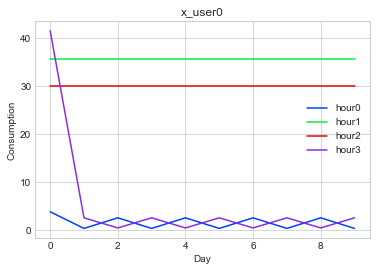

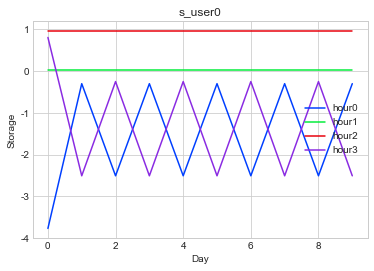

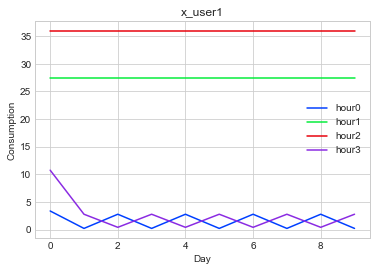

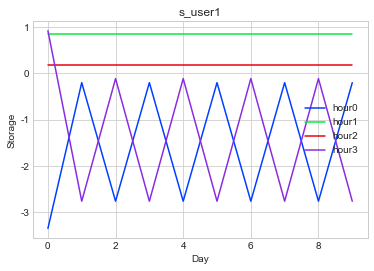

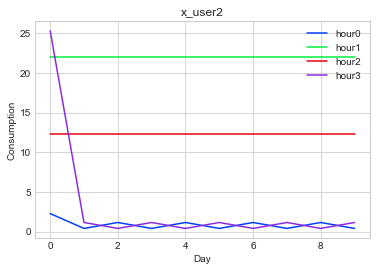

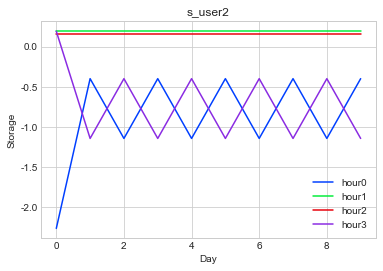

In [56]:
for i in range(N):
    plt.close()
    tmp = pd.DataFrame(user_x_list[i].T,columns = ['hour0','hour1','hour2','hour3']) 
    plt.plot(tmp)
    plt.xlabel('Day')
    plt.ylabel('Consumption')
    plt.title('x_user{}'.format(i))
    plt.legend(labels = ['hour0','hour1','hour2','hour3'],loc = 'best')
    #plt.savefig('%i-x.pdf' % i)
    plt.show()
    plt.close()
    tmp = pd.DataFrame(user_s_list[i].T,columns = ['hour0','hour1','hour2','hour3']) 
    plt.plot(tmp)
    plt.xlabel('Day')
    plt.ylabel('Storage')
    plt.legend(labels = ['hour0','hour1','hour2','hour3'],loc = 'best')
    plt.title('s_user{}'.format(i))
    plt.show()

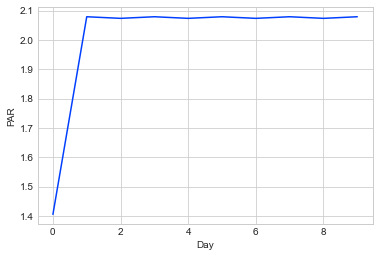

In [58]:
PAR(user_x_list,user_s_list)